In [98]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import os
import sys
import os
from tqdm import tqdm
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT
import seaborn as sns
from peft import LoraConfig, get_peft_model
from matplotlib import pyplot as plt
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from datasets import concatenate_datasets

def load_data(DATASET_NAME, tasks, eval = False):

    if DATASET_NAME == "databricks/databricks-dolly-15k":
        dataset = load_dataset(DATASET_NAME, split="train")
        dataset = dataset.train_test_split(test_size=0.2, seed=0)
        if eval:
            dataset = dataset['test']
        else:
            dataset = dataset['train']
        dataset = dataset.filter(lambda x: x['category'] in tasks) #['open_qa', 'general_qa', 'closed_qa', 'classification', 'brainstorming', 'information_extraction', 'summarization'])
        dataset = dataset.map(dolly_format)
        return dataset
    
    if DATASET_NAME == "CohereForAI/aya_dataset":

        dataset = load_dataset(DATASET_NAME, split="train")

        languages = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish'] #filtrar nas linguas
        dataset = dataset.filter(lambda x: x['language'] in languages)

        dataset = dataset.train_test_split(test_size=0.2, seed=0)
        if eval:
            dataset = dataset['test']
        else:
            dataset = dataset['train']
        dataset = dataset.filter(lambda x: x['language'] in tasks) 
        dataset = dataset.map(aya_format)
        return dataset

    if DATASET_NAME == 'multitask':
        if tasks == 'boolq':
            dataset = prepare_boolq(eval=eval)
            dataset = dataset.shuffle(seed=0)
            return dataset
        if tasks == 'webnlg':
            dataset = prepare_webnlg(eval=eval)
            dataset = dataset.shuffle(seed=0)
            return dataset
        if tasks == 'samsum':
            dataset = prepare_samsum(eval=eval)
            dataset = dataset.shuffle(seed=0)
            return dataset
        if tasks == 'gigaword':
            dataset = prepare_gigaword(eval=eval)
            dataset = dataset.shuffle(seed=0)
            return dataset
        if tasks == 'all_tasks':
            #selecting only "instruction" and "response" columns
            boolq = prepare_boolq(eval=eval).map(lambda x: {'instruction': x['instruction'], 'response': x['response'], 'task': 'boolq'})
            webnlg = prepare_webnlg(eval=eval).map(lambda x: {'instruction': x['instruction'], 'response': x['response'], 'task': 'webnlg'})
            samsum = prepare_samsum(eval=eval).map(lambda x: {'instruction': x['instruction'], 'response': x['response'], 'task': 'samsum'})
            gigaword = prepare_gigaword(eval=eval).map(lambda x: {'instruction': x['instruction'], 'response': x['response'], 'task': 'gigaword'})
            
            dataset = concatenate_datasets([boolq, webnlg, samsum, gigaword])
            dataset = dataset.shuffle(seed=0)
            return dataset

def prepare_webnlg(eval = False):
    dataset = load_dataset('GEM/web_nlg', 'en', split = 'train')
    dataset = dataset.train_test_split(test_size=0.2, seed=0)

    if eval:
        dataset = dataset['test']
    else:
        dataset = dataset['train']
    
    dataset = dataset.map(webnlg_format)

    return dataset

def prepare_boolq(eval = False):
    dataset = load_dataset('google/boolq', split = 'train')
    dataset = dataset.train_test_split(test_size=0.2, seed=0)

    if eval:
        dataset = dataset['test']
    else:
        dataset = dataset['train']
    
    dataset = dataset.map(boolq_format)

    return dataset

def prepare_samsum(eval = False):
    dataset = load_dataset('Samsung/samsum', split = 'train', trust_remote_code=True)
    dataset = dataset.train_test_split(test_size=0.2, seed=0)

    if eval:
        dataset = dataset['test']
    else:
        dataset = dataset['train']

    dataset = dataset.map(samsum_format)

    return dataset

def prepare_gigaword(eval = False):
    dataset = load_dataset('Harvard/gigaword', split = 'train', trust_remote_code=True)
    dataset = dataset.train_test_split(test_size=0.2, seed=0)

    if eval:
        dataset = dataset['test']
    else:
        dataset = dataset['train']
    
    dataset = dataset.shuffle(seed=0)
    dataset = dataset.select(range(30000)) #loading only part (the whole dataset has aroud 4M examples)
    dataset = dataset.map(gigaword_format)

    return dataset

def boolq_format(example):
    example["instruction"] = example['passage'] + " Based on the passage, answer this question:" + example['question']
    example["response"] = str(example['answer'])
    return example

def webnlg_format(example):
    example['input'] = str(example['input'])
    example["instruction"] = "Organize this data into a readable text: " + example['input']
    example["response"] = example['target']
    return example

def samsum_format(example):
    example["instruction"] = "Summarize this conversation: " + example['dialogue']
    example["response"] = example['summary']
    return example

def gigaword_format(example):
    example["instruction"] = "Summarize this text: " + example['document']
    example["response"] = example['summary']
    return example

def dolly_format(example):
    if example['context'] == "":
        example["inputs"] = example["instruction"]
    else:
        example["inputs"] = example["instruction"] + " " + example['context']
    return example

def aya_format(example):
    example["instruction"] = example['inputs']
    example["response"] = example['targets']

    return example

alpaca_template = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{} 

### Response: {}{}"""

TEMPLATE_DICT = {
    'alpaca': (alpaca_template, '\n### Response:'),
}

def get_formatting_prompts_func(template_name, eos_token):
    if template_name in TEMPLATE_DICT:
        overall_temp, response_temp = TEMPLATE_DICT[template_name]
        def formatting_prompts_func(example):    
            #output_texts = []    
            text = overall_temp.format(example['instruction'], example['response'], eos_token)
            #output_texts.append(text)    
            return text#output_texts

    elif template_name == 'ag_news':

        formatting_prompts_func = None
        response_temp = None
    
    return formatting_prompts_func, response_temp


In [99]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [88]:
model_name = "HuggingFaceTB/SmolLM-360M"
model = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [154]:
def get_embeddings_model(text, model):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        outputs = model(**inputs, output_hidden_states=True)
        embedding = outputs.hidden_states[-1].mean(dim=1)
    return embedding

In [163]:
DATASET_NAME = 'CohereForAI/aya_dataset'
DATASET_NAME = 'multitask'

tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
tasks = 'all_tasks'

data = load_data(DATASET_NAME, tasks, eval = False)
#data = data.map(aya_format)
data = data.select(range(1000))

In [167]:
embeddings = []
tasks = []

for i in range(len(data)):
    if i % 100 == 0:
        print(i)
    text = data[i]['instruction']
    tasks.append(data[i]['task'])
    embedding = get_embeddings_model(text, model)
    embeddings.append(embedding)

0
100
200
300
400
500
600
700
800
900


<Axes: >

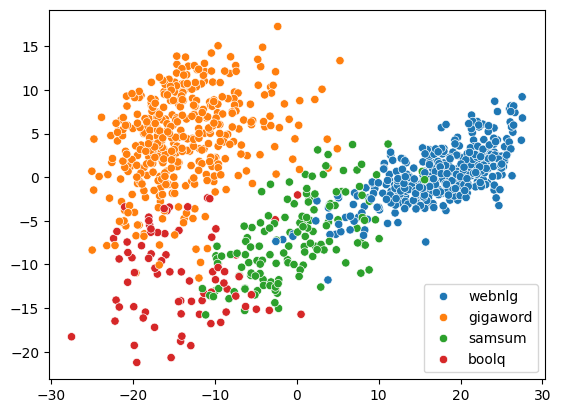

In [168]:
#pca

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
embeddings = torch.cat(embeddings, dim=0).cpu().numpy()
pca_embeddings = pca.fit_transform(embeddings)

sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=tasks)
